# Michelin Star Restaurant Exploration and Star Classification

Coded by Luna McBride

Note from the dataset: explicitly not including these regions: Belgium, France, Germany, Italy, Japan, Luxembourg, Netherlands, Portugal, China, Spain, and Switzerland

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split #Split the data into train and test
from sklearn.ensemble import RandomForestClassifier #Forest for classification
from sklearn.metrics import mean_squared_error #Error testing
from sklearn.metrics import classification_report #Report of Classification

from mpl_toolkits.basemap import Basemap #Plot onto map
import geopy #Zip Code Tracker (in this case)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,10) #Set the default figure size
plt.style.use('ggplot') #Set the plotting method

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/michelin-restaurants/one-star-michelin-restaurants.csv
/kaggle/input/michelin-restaurants/three-stars-michelin-restaurants.csv
/kaggle/input/michelin-restaurants/two-stars-michelin-restaurants.csv


In [2]:
oneStar = pd.read_csv("../input/michelin-restaurants/one-star-michelin-restaurants.csv") #Load 1 star restaurants
twoStar = pd.read_csv("../input/michelin-restaurants/two-stars-michelin-restaurants.csv") #Load 2 star restaurants
threeStar = pd.read_csv("../input/michelin-restaurants/three-stars-michelin-restaurants.csv") #Load 3 star restaurants
threeStar.head() #Take a peek at some of the datasets

,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url
0,Amador,2019,48.25406,16.35915,Wien,Austria,1190,Creative,$$$$$,https://guide.michelin.com/at/en/vienna/wien/r...
1,Manresa,2019,37.22761,-121.98071,South San Francisco,California,95030,Contemporary,$$$$,https://guide.michelin.com/us/en/california/so...
2,Benu,2019,37.78521,-122.39876,San Francisco,California,94105,Asian,$$$$,https://guide.michelin.com/us/en/california/sa...
3,Quince,2019,37.79762,-122.40337,San Francisco,California,94133,Contemporary,$$$$,https://guide.michelin.com/us/en/california/sa...
4,Atelier Crenn,2019,37.79835,-122.43586,San Francisco,California,94123,Contemporary,$$$$,https://guide.michelin.com/us/en/california/sa...


---

# Combine the Datasets

In [3]:
oneStar["star"] = 1 #Fill the one star sets with 1
twoStar["star"] = 2 #Fill the two star sets with 2
threeStar["star"] = 3 #Fill the three star sets with 3
threeStar.head() #Take a peek at one of the sets

,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url,star
0,Amador,2019,48.25406,16.35915,Wien,Austria,1190,Creative,$$$$$,https://guide.michelin.com/at/en/vienna/wien/r...,3
1,Manresa,2019,37.22761,-121.98071,South San Francisco,California,95030,Contemporary,$$$$,https://guide.michelin.com/us/en/california/so...,3
2,Benu,2019,37.78521,-122.39876,San Francisco,California,94105,Asian,$$$$,https://guide.michelin.com/us/en/california/sa...,3
3,Quince,2019,37.79762,-122.40337,San Francisco,California,94133,Contemporary,$$$$,https://guide.michelin.com/us/en/california/sa...,3
4,Atelier Crenn,2019,37.79835,-122.43586,San Francisco,California,94123,Contemporary,$$$$,https://guide.michelin.com/us/en/california/sa...,3


In [4]:
datasets = [oneStar, twoStar, threeStar] #Take the three datasets
stars = pd.concat(datasets) #Combine the datasets
stars = stars.reset_index() #Reset the index
stars.head() #Take a peek at the combined dataset

,index,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url,star
0,0,Kilian Stuba,2019,47.348580,10.17114,Kleinwalsertal,Austria,87568,Creative,$$$$$,https://guide.michelin.com/at/en/vorarlberg/kl...,1
1,1,Pfefferschiff,2019,47.837870,13.07917,Hallwang,Austria,5300,Classic cuisine,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...,1
2,2,Esszimmer,2019,47.806850,13.03409,Salzburg,Austria,5020,Creative,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...,1
3,3,Carpe Diem,2019,47.800010,13.04006,Salzburg,Austria,5020,Market cuisine,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...,1
4,4,Edvard,2019,48.216503,16.36852,Wien,Austria,1010,Modern cuisine,$$$$,https://guide.michelin.com/at/en/vienna/wien/r...,1


---

# Check for Null Values

In [5]:
print(stars.isnull().any()) #Check for null values

index        False
name         False
year         False
latitude     False
longitude    False
city          True
region       False
zipCode       True
cuisine      False
price         True
url          False
star         False
dtype: bool


Price is in the form of $'s. I will just add a ? to hold that place.

The only null cities have a region of Hong Kong, which I will just fill with Hong Kong because it is a city.

The zip codes can be gotten from the lat/long data via GeoPy, which have no null items.

---

# Fix Null Values

## Price

In [6]:
stars["price"] = stars["price"].fillna("?") #Fill null prices with unknown ?
print(stars.isnull().any()) #Make sure all null values are filled

index        False
name         False
year         False
latitude     False
longitude    False
city          True
region       False
zipCode       True
cuisine      False
price        False
url          False
star         False
dtype: bool


## City

In [7]:
stars["city"] = stars["city"].fillna("Hong Kong") #Fill the null cities will Hong Kong, since all of the null ones are in HK
print(stars.isnull().any()) #Make sure that filled the nulls

index        False
name         False
year         False
latitude     False
longitude    False
city         False
region       False
zipCode       True
cuisine      False
price        False
url          False
star         False
dtype: bool


## Zip Code

Zip Encoding: https://gis.stackexchange.com/questions/352961/convert-lat-lon-to-zip-postal-code-using-python

In [8]:
print(stars.loc[stars["zipCode"].isnull()][:4])

     index                    name  year   latitude   longitude  \
59      59            Harbor House  2019  39.135876 -123.719444   
87      87                Temporis  2019  41.898907  -87.667250   
137    137                 Loaf On  2019  22.379858  114.271880   
138    138  Lei Garden (Kwun Tong)  2019  22.312672  114.224820   

              city      region zipCode       cuisine price  \
59   San Francisco  California     NaN   Californian  $$$$   
87         Chicago     Chicago     NaN  Contemporary  $$$$   
137      Hong Kong   Hong Kong     NaN     Cantonese    $$   
138      Hong Kong   Hong Kong     NaN     Cantonese     $   

                                                   url  star  
59   https://guide.michelin.com/us/en/california/sa...     1  
87   https://guide.michelin.com/us/en/illinois/chic...     1  
137  https://guide.michelin.com/hk/en/hong-kong-reg...     1  
138  https://guide.michelin.com/hk/en/hong-kong-reg...     1  


In [9]:
geolocator = geopy.Nominatim(user_agent = "user_agent") #Get the geolocator

# For each row, fill null postcodes
for i in range(0, len(stars.index)):
    zipCode = stars["zipCode"][i] #Get the zipcode
    
    #If the zipcode is null
    if zipCode is np.nan:
        location = geolocator.reverse((stars["latitude"][i], stars["longitude"][i])) #Get the zip code from the geolocator
        
        #Try to get the postcode/zipcode field from the locator
        try:
            stars["zipCode"][i] = location.raw["address"]["postcode"] #Get the zip code
        
        #Fill the code with 00000 if the code cannot be accessed
        except:
            stars["zipCode"][i] = "00000" #Fill the zip code with 00000
        
print(stars.isnull().any()) #Make sure the null values have been filled

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index        False
name         False
year         False
latitude     False
longitude    False
city         False
region       False
zipCode      False
cuisine      False
price        False
url          False
star         False
dtype: bool


In [10]:
print(stars.loc[[59]]) #Print a row with the zip code filled
print(stars.loc[[137]]) #Print a Hong Kong row that was null, which has no zip code field, so fill with 00000

    index          name  year   latitude   longitude           city  \
59     59  Harbor House  2019  39.135876 -123.719444  San Francisco   

        region zipCode      cuisine price  \
59  California   95482  Californian  $$$$   

                                                  url  star  
59  https://guide.michelin.com/us/en/california/sa...     1  
     index     name  year   latitude  longitude       city     region zipCode  \
137    137  Loaf On  2019  22.379858  114.27188  Hong Kong  Hong Kong   00000   

       cuisine price                                                url  star  
137  Cantonese    $$  https://guide.michelin.com/hk/en/hong-kong-reg...     1  


---

# Plot on a Map

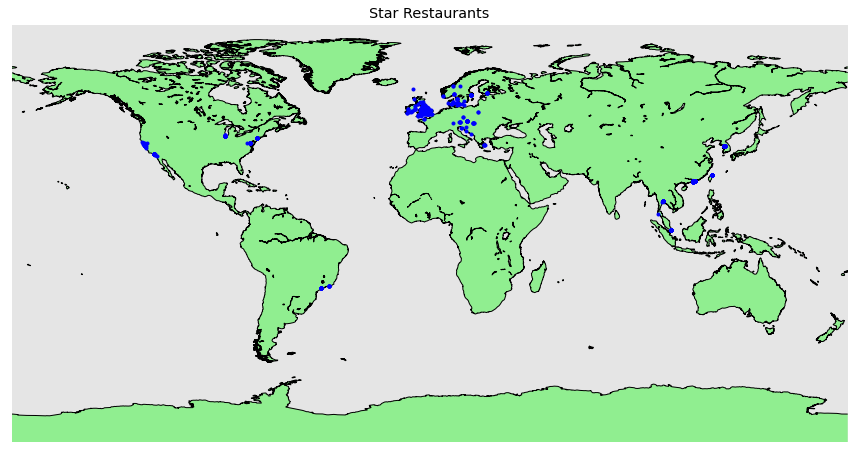

In [11]:
lat = list(stars["latitude"]) #Get the list of latitudes
lon = list(stars["longitude"]) #Get the list of longitudes

plt.title("Star Restaurants") #Add a title for the restaurants

#Set a basemap for the world
mRes = Basemap(width = 10000000, height = 10000000, projection = "cyl",
            resolution = "l", lat_1 = 50.0, lat_2 = 0.0, lat_0 = 25.0, lon_0 = 0.0)

mRes.drawcoastlines() #Draw the coastlines
mRes.fillcontinents(color = "lightgreen") #Make the land light green
xlon, ylat = mRes(lon, lat) #Fit the coordinates to fit with the map
mRes.plot(xlon, ylat, "b.") #Plot the restaurants

It seems this dataset specifically ignores various countries. The UK is littered with them, along with some in central Europe and Scandinavia. Other than that, restaurants are pretty sparce.

---

# Plot Different Colors for Different Star Numbers

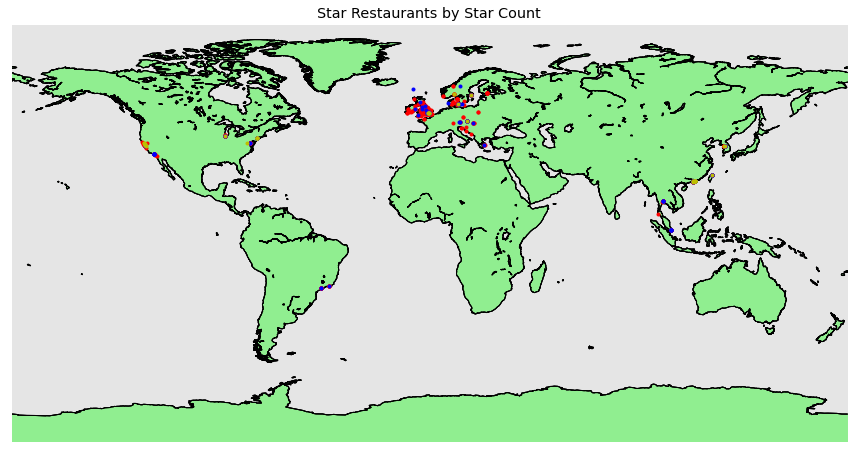

In [12]:
colors = ["r.", "b.", "y."] #Define our colors
i = 0 #Add an iterator for our colors

for star in stars["star"].unique():
    newStat = stars.loc[stars["star"] == star] #Get the restaurants by star amount
    lat = list(newStat["latitude"]) #Get the list of latitudes
    lon = list(newStat["longitude"]) #Get the list of longitudes

    plt.title("Star Restaurants by Star Count") #Add a title for the restaurants

    #Set a basemap for the world
    mRes = Basemap(width = 10000000, height = 10000000, projection = "cyl",
                resolution = "l", lat_1 = 50.0, lat_2 = 0.0, lat_0 = 25.0, lon_0 = 0.0)

    mRes.drawcoastlines() #Draw the coastlines
    mRes.fillcontinents(color = "lightgreen") #Make the land light green
    xlon, ylat = mRes(lon, lat) #Fit the coordinates to fit with the map
    mRes.plot(xlon, ylat, colors[i]) #Plot the restaurants
    
    i += 1 #Change the color

The gold (3 star) appear to be located in the bigger areas of bigger countries in this dataset (ie around the major cities of San Francisco, Chicago, and New York in the US). I will need to zoom into Europe for a better understanding.

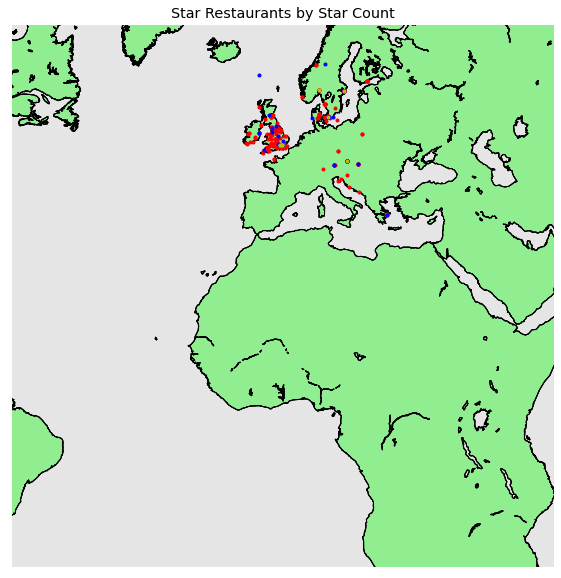

In [13]:
colors = ["r.", "b.", "y."] #Define our colors
i = 0 #Add an iterator for our colors

for star in stars["star"].unique():
    newStat = stars.loc[stars["star"] == star] #Get the restaurants by star amount
    lat = list(newStat["latitude"]) #Get the list of latitudes
    lon = list(newStat["longitude"]) #Get the list of longitudes

    plt.title("Star Restaurants by Star Count") #Add a title for the restaurants

    #Set a basemap for the Europe
    mRes = Basemap(width = 10000000, height = 10000000, projection = "lcc",
                resolution = "l", lat_1 = 50.0, lat_2 = 0.0, lat_0 = 25.0, lon_0 = 0.0)

    mRes.drawcoastlines() #Draw the coastlines
    mRes.fillcontinents(color = "lightgreen") #Make the land light green
    xlon, ylat = mRes(lon, lat) #Fit the coordinates to fit with the map
    mRes.plot(xlon, ylat, colors[i]) #Plot the restaurants
    
    i += 1 #Change the Color

My previous statement is affirmed by the 3 star restaurant in Vienna. I will need to zoom in closer to look at the UK and Scandinavia. I assume, since countries like France and Italy were explicitly excluded from the dataset, that they would look like the UK if they were included.

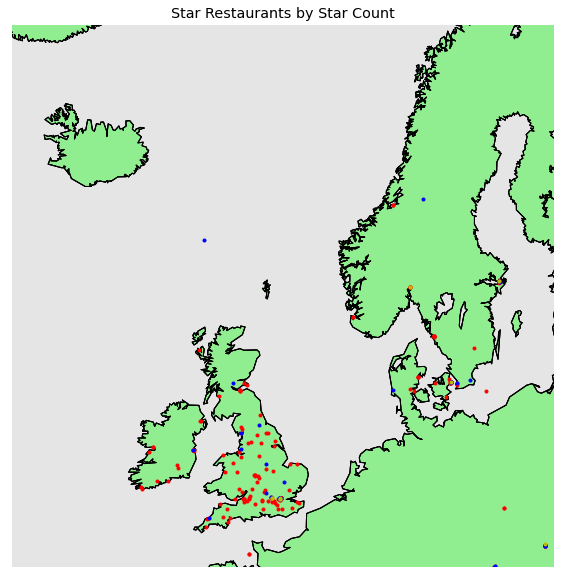

In [14]:
colors = ["r.", "b.", "y."] #Define our colors
i = 0 #Add an iterator for our colors

for star in stars["star"].unique():
    newStat = stars.loc[stars["star"] == star] #Get the restaurants by star amount
    lat = list(newStat["latitude"]) #Get the list of latitudes
    lon = list(newStat["longitude"]) #Get the list of longitudes

    plt.title("Star Restaurants by Star Count") #Add a title for the restaurants

    #Set a basemap for the UK
    mRes = Basemap(width = 2500000, height = 2500000, projection = "lcc",
                resolution = "l", lat_1 = 70.0, lat_2 = 50.0, lat_0 = 60.0, lon_0 = 0.0)

    mRes.drawcoastlines() #Draw the coastlines
    mRes.fillcontinents(color = "lightgreen") #Make the land light green
    xlon, ylat = mRes(lon, lat) #Fit the coordinates to fit with the map
    mRes.plot(xlon, ylat, colors[i]) #Plot the restaurants
    
    i += 1 #Change the Color

Of course the 3 star areas are the large ones, namely London, Stolkholm, Copenhagen, and Oslo. I am honestly surprised how many restaurants have at least one star, especially in England and Wales specifically (ignoring Scotland and Northern Ireland). I was also nervous about the two locations located in seemingly the middle of the water near Sweden and above Scotland, but a look at Google Maps tells me those are on Bornholm and the Faroe Islands respectively.

---

# Star Classification

In [15]:
#GetChara: Get the most important characteristics to the classification
#Input: the characteristics, the model
#Output: None
def getChara(characteristics, forest):
    attributes = characteristics.columns #Get the tested attributes
    attributes = list(zip(attributes, forest.feature_importances_)) #Zip the attributes together with their coefficient
    sortAtt = sorted(attributes, key = lambda x: x[1], reverse = True) #Sort the zipped attributes by their coefficients

    print("According to the Random Forest, the most important factors for restaurant stars are: ") #Start printing the most important labels
    i = 0 #Counter variable so only the top five are printed

    #For each attribute in the sorted attributes
    for label, coef in sortAtt:
        if i < 5: #If there has not been five printed yet
            print(label) #Print the label as an important factor
        i += 1 #Increase i by 1

#ClassifyStars: Classify which restaurants are 1/2/3 stars
#Input: The dataframe for the restaurants, the labels used
#Output: None
def classifyStars(stars, labels):
    star = stars["star"].copy() #Get the star as our classification metric
    star = pd.get_dummies(star) #Get dummies for the star metric

    characteristics = stars.drop(columns = {"star"}).copy() #Get the characteristics used for classification
    characteristics = pd.get_dummies(characteristics)
    
    charaTrain, charaTest, starTrain, starTest = train_test_split(characteristics, star, test_size = 0.3) #Split the dataset
    
    forest = RandomForestClassifier(n_estimators = 100) #Build a forest
    forest.fit(charaTrain, starTrain) #Fit the forest model
    
    predict = forest.predict(charaTest) #Get a list of predictions
    
    print("Forest Accuracy: ", forest.score(charaTest, starTest)) #Print the accuracy
    print("Root Mean Square Error: ", np.sqrt(mean_squared_error(starTest, predict))) #Print the root mean square error
    print("Classification Report:\n ", classification_report(starTest, predict, target_names = labels, zero_division = 0)) #Print a classification report
    
    getChara(characteristics, forest) #Get the important Characteristics

In [16]:
#Try dropping the index column
try:
    stars = stars.drop(columns = "index") #Drop the index column

#Fill the except clause so it does not throw the error
except:
    a = 1 #Filler
    
#What to do after the index is dropped
finally:
    labels = ["1", "2", "3"] #Set the labels
    classifyStars(stars, labels) #Classify by star amount

Forest Accuracy:  0.7703349282296651
Root Mean Square Error:  0.38096662083205896
Classification Report:
                precision    recall  f1-score   support

           1       0.80      0.99      0.88       163
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        11

   micro avg       0.79      0.77      0.78       209
   macro avg       0.27      0.33      0.29       209
weighted avg       0.62      0.77      0.69       209
 samples avg       0.77      0.77      0.77       209

According to the Random Forest, the most important factors for restaurant stars are: 
longitude
latitude
price_$$$$
cuisine_Contemporary
zipCode_10019


The size difference between the number of 1 star restaurants versus the others made it hard for it to classify the other ones at all. This made for a 83% classification rate, but it kept missing all the other labels.